# bird data reading and plotting
### oregional code was done by Doruk 
### Modified by X. Liu on Oct 12, 2023 (from py to ipynb)

In [91]:
# Instructions
# satellite data: Feb 20 & 21 2021 missing

# This version compares all the _START_END signals (i.e., surface measurements),
# with the Original and Modified (Marvin) model results as well as the satellite.

# May2022: So this code uses the data processed by my quick script. However then
# I moved on modifying Dylan's processing scripts, hence try to use that for
# profile comparisons.

# TODO: select comparison plot time index

# Only model surface information is used in this version.

# xr.open_mfdataset(files) automatically combines all the files. It worked for
# time dimension without any issues. It uses "dask" module and chunking which
# is super fast so it can handle large file sizes as well.

# Interpolation and advanced indexing is a bit complex 
# https://xarray.pydata.org/en/stable/user-guide/interpolation.html#advanced-interpolation

In [ ]:
import pandas as pd
import xarray as xr
import numpy as np
import netCDF4
# import nc_time_axis
import matplotlib.pyplot as plt
import glob
import cmocean
import xskillscore as xs
# from sklearn.metrics import mean_squared_error

import h5py
from scipy.io import loadmat

# 1. Load Data

## 1.0 Load topography data (to mask ocean-dust data )

In [405]:
ds_topo_etopo1 = xr.open_dataset('/home/server/pi/homes/liux8/work/general_data/topography/etopo1.nc',mode='r')

/home/server/pi/homes/liux8/.conda/envs/dev_scipy/lib/python3.11/site-packages/xarray/coding/times.py:210: CFWarning: this date/calendar/year zero convention is not supported by CF
  cftime.num2date(num_dates, units, calendar, only_use_cftime_datetimes=True)
/home/server/pi/homes/liux8/.conda/envs/dev_scipy/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/server/pi/homes/liux8/.conda/envs/dev_scipy/lib/python3.11/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()


In [486]:
# [londusm,latdusm] = meshgrid(londus,latdus);
bathy_pg = ds_topo_etopo1.interp(LON=ds_dust.lon,LAT=ds_dust.lat);

mask_pg = bathy_pg.B_BATHY.copy();
mask_pg2 = mask_pg.where(mask_pg<0,np.nan)
mask_pg2 = mask_pg2.where(np.isnan(mask_pg2),1)
    
bathy_pg = bathy_pg.update({'mask':mask_pg2})

mask_pg = bathy_pg.B_BATHY.copy();
mask_pg3 = mask_pg.where(mask_pg>1,1)
mask_pg3 = mask_pg3.where(mask_pg<0,0)
    
bathy_pg = bathy_pg.update({'mask2':mask_pg3})

## 1.1 Load bird data

In [3]:
CLim_l=15
CLim_h=40
ms1=1
# file1='Nov_Dec_2020.csv'
# file1='3min_Jan_Mar_2021.csv' ;ptime=15
# file1='surf_processed/Jan_Mar_2021.csv' ;ptime=15

file1='surf_processed/All_2021_3min_with_id.csv'; ptime=165
# file1='surf_processed/Jul_Sep_2021.csv'; ptime=220
# file1='surf_processed/Oct_Dec_2021.csv'

yr=file1[-21:-17]
# yr=file1[-13:-9]
df = pd.read_csv(file1,parse_dates=True,index_col='UTC_datetime')

#READ MARVIN'S MODIFIED MODEL RESULT AND ORIGINAL SHORTWAVE RAD

def RMSE(x,y):
    mse = np.square(np.subtract(x,y)).mean() 
    return np.sqrt(mse)

In [5]:
# df1 = df.loc[df['device_id']==203013]

x = xr.DataArray(df.Longitude_1, dims="t")
y = xr.DataArray(df.Latitude_1, dims="t")
t = xr.DataArray(df.date, dims="t")
did = xr.DataArray(df.device_id, dims="t")
temp = xr.DataArray(df.ext_temperature_C, dims="t")
conduc = xr.DataArray(df['conductivity_mS/cm'], dims="t")

ds_obs = xr.Dataset({
    'x': x,
    'y': y,
    't0': t,
    'id': did,
    'temp': temp,
    'cond': conduc
})

In [51]:
df.device_id.unique()

array([203018, 203013, 203014, 203034, 203029, 201420, 201410, 201411])

In [54]:
# ta = ds_obs.temp.where('id'==203018).groupby("t.dayofyear").mean(dim='t')
ta0 = ds_obs['temp'].where(ds_obs['id']==203018,drop=True).groupby("t.dayofyear").mean(dim='t')

In [360]:
ca0 = ds_obs['cond'].where(ds_obs['id']==203018,drop=True).groupby("t.dayofyear").mean(dim='t')

## 1.2 load dust data

In [6]:
## load 2021 dust data
with h5py.File('/home/server/pi/homes/liux8/work/GETM/capefalconBuild/input_xiaohui_revised/Meteo_v2_1/forcing/dust_2021_MERRA2_hourly.mat', 'r') as file:
    def print_attrs(name, obj):
        print(name)
        for key, val in obj.attrs.items():
            print(f"    {key}: {val}")

    file.visititems(print_attrs)

    # 读取数据集
    dust2021 = file['dust_cum_a'][:]
    latdus = file['latdus'][:]
    londus = file['londus'][:]

da_dust = xr.DataArray(dust2021, coords={'lon': londus[0,:], 'lat': latdus[0,:], 'time': np.arange(0,8760*3600,3600)},
                  dims=['time', 'lat', 'lon'])

ds_dust = xr.Dataset({'dust_dens': da_dust})

ds_dust['time'] = pd.to_datetime(ds_dust['time'].values,unit='s')+pd.DateOffset(years=51)

ds_dust_daily = ds_dust.groupby("time.dayofyear").mean(dim="time")

dust_cum_a
    MATLAB_class: b'double'
latdus
    MATLAB_class: b'double'
londus
    MATLAB_class: b'double'


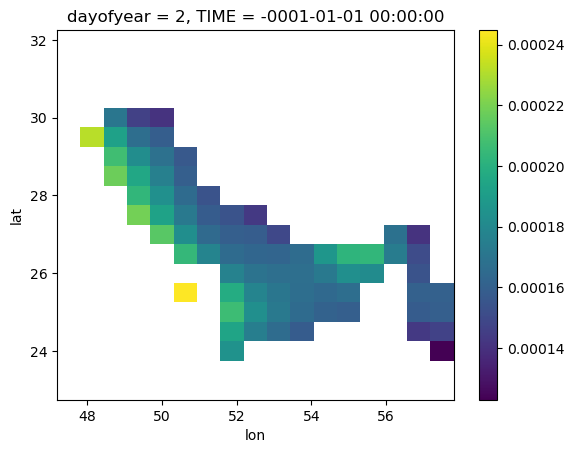

In [437]:
(ds_dust_daily.dust_dens*bathy_pg.mask.isel(TIME=0)).isel(dayofyear=1).plot()

In [51]:
dust_cum_sum_hourly = loadmat('/home/server/pi/homes/liux8/work/GETM/capefalconBuild/input_xiaohui_revised/Meteo_v2_1/forcing/dust_cum_sum_hourly.mat')['dust_cum_sum']
# mean over the Gulf
da_dust_longterm_avg = xr.DataArray(dust_cum_sum_hourly, coords={'year':np.arange(0,15,1),'time': np.arange(0,8760*3600,3600)},
                  dims=['time', 'year'])

da_dust_longterm_avg['time'] = pd.to_datetime(da_dust_longterm_avg['time'].values,unit='s')+pd.DateOffset(years=51)
# dust_cum_sum_daily = np.mean(dust_cum_sum_hourly,1)

da_dust_clim_avg = da_dust_longterm_avg.mean(dim='year').groupby('time.dayofyear').mean(dim='time')

## 1.3 load SST (OBS) data

In [7]:
with h5py.File('/home/server/pi/homes/liux8/work/OBS/xliu_obs_process/sst_clim_MUR.mat', 'r') as file:
    def print_attrs(name, obj):
        print(name)
        for key, val in obj.attrs.items():
            print(f"    {key}: {val}")

    file.visititems(print_attrs)

    # 读取数据集
    sst_clim = file['sst_clim'][:]
#     lon_clim = file['latdus'][:]
#     lat_clim = file['londus'][:]
lon0 = loadmat('/home/server/pi/homes/liux8/work/OBS/xliu_obs_process/sst_lonlat_MUR.mat')['lon']
lat0 = loadmat('/home/server/pi/homes/liux8/work/OBS/xliu_obs_process/sst_lonlat_MUR.mat')['lat']
ilon = loadmat('/home/server/pi/homes/liux8/work/OBS/xliu_obs_process/sst_ilon_ilat_MUR.mat')['ilon1']
jlat = loadmat('/home/server/pi/homes/liux8/work/OBS/xliu_obs_process/sst_ilon_ilat_MUR.mat')['jlat1']

lon_mur = lon0[ilon[0,0].astype(int)-1:ilon[-1,0].astype(int)]
lat_mur = lat0[jlat[0,0].astype(int)-1:jlat[-1,0].astype(int)]

sst_clim
    MATLAB_class: b'double'


In [8]:
da_mur_clim = xr.DataArray(sst_clim, coords={'lon': lon_mur[:,0], 'lat': lat_mur[:,0], 'time': np.arange(365)},
                  dims=['time', 'lat', 'lon'])

# da2_mur = da_mur.interp(lon=datasets_era[0].lonc,lat=datasets_era[0].latc,method='linear')

ds_mur_clim = xr.Dataset({'sst': da_mur_clim})
ds_mur_clim['time'] = pd.to_datetime(ds_mur_clim['time'].values,unit='D')+pd.DateOffset(years=51)

# get monthyly average 
# ds_mur_monthly = ds_mur.resample(time='1M').mean()

## 1.4 Load Model (Surface) data 

In [9]:
runname = '~/work/GETM/hpc2-files/GETM_shrad/getm/setups/era5frc_coldstart_01012017_era5v6/data_results_2021/';

# datasets_era_v6 = []
# for im in range(1,13): 
#     datatype = 'data/regions/mean_mon'+str(im)

#     data_name = runname+datatype
#     file_3d = data_name+'.nc'
    
#     print("  Opening %s  file "%file_3d)
#     ds = xr.open_dataset(file_3d,mode='r')
#     datasets_era_v6.append(ds)
    
datatype = 'data/regions/surface'

data_name = runname+datatype
file_3d = data_name+'.nc'

print("  Opening %s  file "%file_3d)
ds_sur_era_v6 = xr.open_dataset(file_3d,mode='r')

  Opening ~/work/GETM/hpc2-files/GETM_shrad/getm/setups/era5frc_coldstart_01012017_era5v6/data_results_2021/data/regions/surface.nc  file 


# 2. data Proc

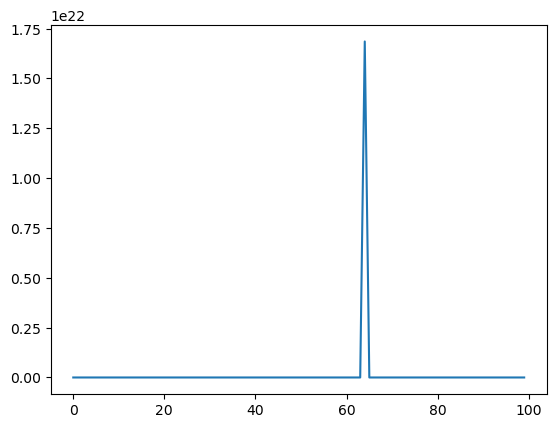

In [10]:
# ds_obs.plot.scatter(x=x.where(x!=0, drop=True),y=y.where(x!=0, drop=True))
# ds_obs.plot.scatter(x=x,y=y)
ds_obs

x_data = ds_obs['x']
y_data = ds_obs['y']
t_data = ds_obs['temp']

mask = (x_data != 0) & (y_data != 0)

x_filtered = x_data[mask]
y_filtered = y_data[mask]
t_filtered = t_data[mask]


# plt.scatter(x_filtered, y_filtered)
# plt.plot(t_filtered[30700:30800])
plt.plot(t_data[30700:30800])

Text(0.5, 1.0, '203018')

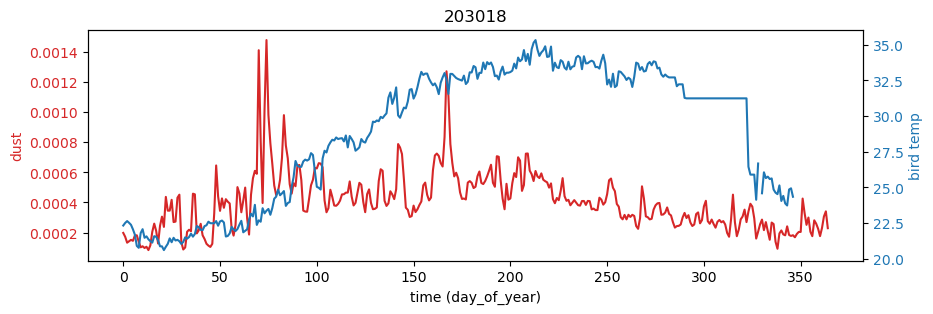

In [441]:
idplt = 203018

ta0 = ds_obs['temp'].where(ds_obs['id']==idplt,drop=True).groupby("t.dayofyear").mean(dim='t')

ta0[ta0<5]=np.nan

# dustplt = ds_dust_daily.dust_dens.mean(dim="lon").mean(dim="lat").data
dustplt = (ds_dust_daily.dust_dens*bathy_pg.mask.isel(TIME=0)).mean(dim="lon").mean(dim="lat").data

fig, ax1 = plt.subplots(figsize=(10,3))

color = 'tab:red'
ax1.set_xlabel('time (day_of_year)')
ax1.set_ylabel('dust', color=color)
ax1.plot(dustplt2, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('bird temp', color=color)  # we already handled the x-label with ax1
ax2.plot(ta0, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.title(str(idplt))


Text(0.5, 1.0, '203018')

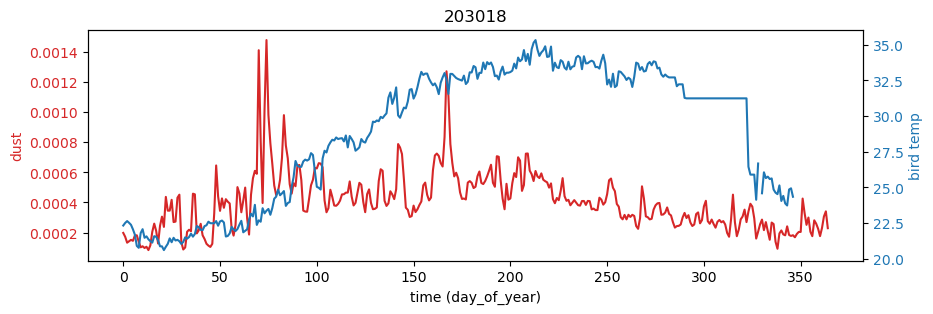

In [442]:
idplt = 203018

ta0 = ds_obs['temp'].where(ds_obs['id']==idplt,drop=True).groupby("t.dayofyear").mean(dim='t')

ta0[ta0<5]=np.nan

dust_msk = ds_dust_daily.dust_dens*bathy_pg.mask.isel(TIME=0)

dustplt = dust_msk.mean(dim="lon").mean(dim="lat").data

fig, ax1 = plt.subplots(figsize=(10,3))

color = 'tab:red'
ax1.set_xlabel('time (day_of_year)')
ax1.set_ylabel('dust', color=color)
ax1.plot(dustplt, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('bird temp', color=color)  # we already handled the x-label with ax1
ax2.plot(ta0, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.title(str(idplt))

Text(0.5, 1.0, '203018')

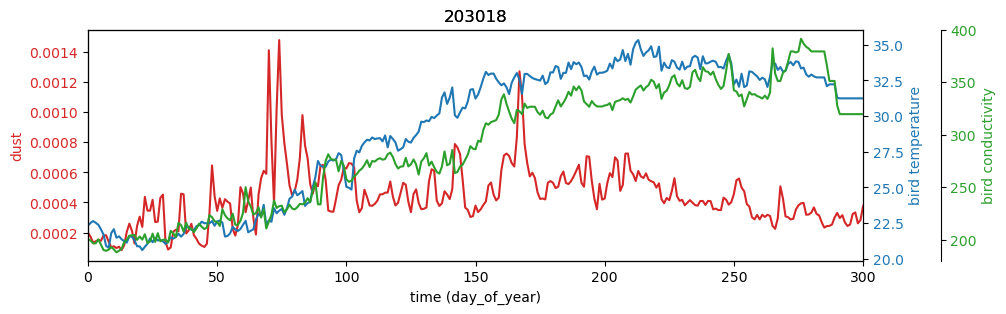

In [443]:
idplt = 203018

ta0 = ds_obs['temp'].where(ds_obs['id']==idplt,drop=True).groupby("t.dayofyear").mean(dim='t')

ta0[ta0<5]=np.nan

dust_msk = ds_dust_daily.dust_dens*bathy_pg.mask.isel(TIME=0)

dustplt = dust_msk.mean(dim="lon").mean(dim="lat").data

fig, ax1 = plt.subplots(figsize=(10,3))

color = 'tab:red'
ax1.set_xlabel('time (day_of_year)')
ax1.set_ylabel('dust', color=color)
ax1.plot(dustplt, color=color)
# ax1.plot(ta0, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('bird temperature', color=color)  # we already handled the x-label with ax1
ax2.plot(ta0, color=color)
ax2.tick_params(axis='y', labelcolor=color)
# ax2.set_ylim(180,400)
ax2.set_xlim(0,300)
plt.title(str(idplt))

ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax3.spines.right.set_position(("axes", 1.1))

color = 'tab:green'
ax3.set_ylabel('bird conductivity', color=color)  # we already handled the x-label with ax1
ax3.plot(ca0, color=color)
ax3.tick_params(axis='y', labelcolor=color)
ax3.set_ylim(180,400)
ax3.set_xlim(0,300)
plt.title(str(idplt))

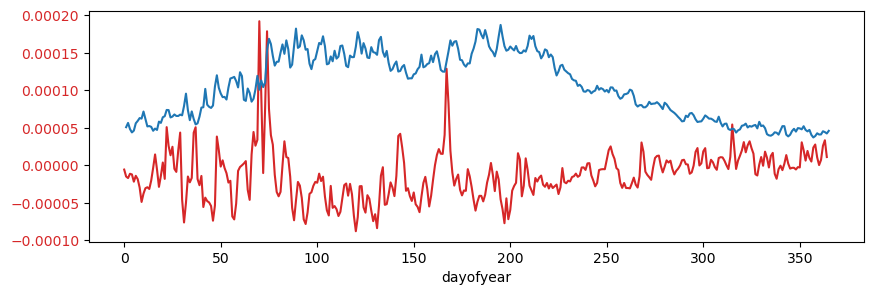

In [125]:
fig, ax1 = plt.subplots(figsize=(10,3))

color = 'tab:red'
ax1.set_xlabel('time (day_of_year)')
ax1.set_ylabel('dust', color=color)
ax1.plot(dustplt-da_dust_clim_avg.data, color=color)
ax1.tick_params(axis='y', labelcolor=color)

da_dust_clim_avg.plot()

Satellite vs. bird: 0.8595532839177971
Orig model vs. bird: 1.1304084782887152
Modified model vs. bird: 1.271610235329639


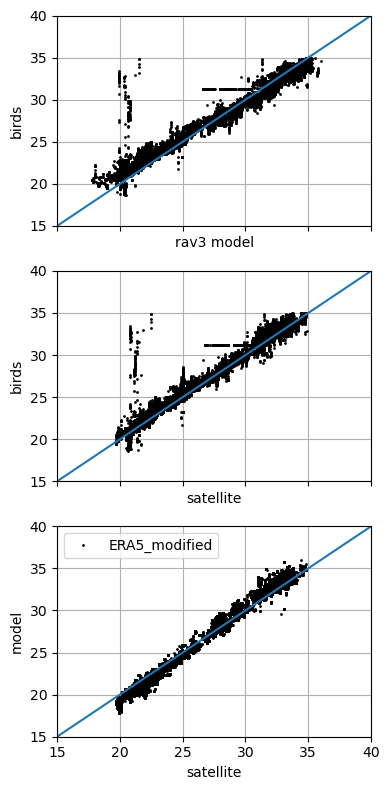

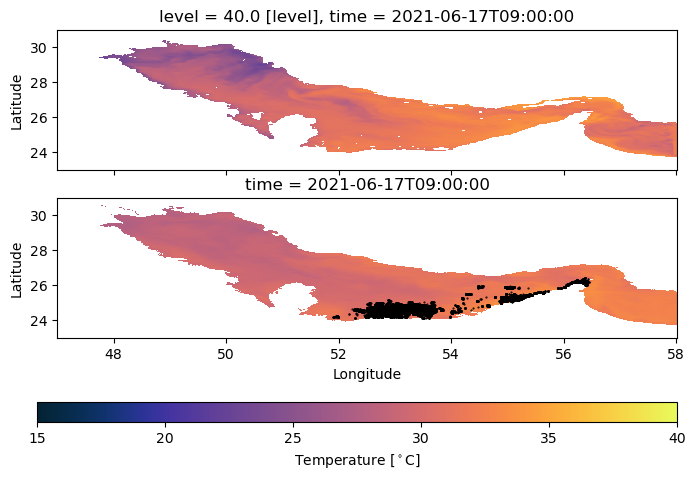

In [14]:
file0 = 'model_satellite/' + yr + '_surf_GETM_marv.nc'
fm_M = xr.open_dataset(file0)
#surface only
fmm2_M=fm_M.isel(level=0)

file0 = 'model_satellite/2021_surf_GETM_erav3.nc'

fm = xr.open_dataset(file0)

fmm2=fm.isel(level=0) #original

df=df.dropna(subset=['Latitude_1'])
df = df[df['ext_temperature_C'] <= 35]
df = df[df['ext_temperature_C'] > 5]

files=glob.glob('model_satellite/' + yr + '_satellite/' + yr + '*subset.nc')
fd=xr.open_mfdataset(files)
sst=fd.analysed_sst-273.15
sst.attrs["units"]="deg C"
sst.attrs["long_name"]="Sea Surface Temperature"
    
fig2,ax_1 = plt.subplots(3,1,figsize=(4, 8),sharey=True,sharex=True)

df['date']=pd.to_datetime(df['date'],format='%Y-%m-%d %H:%M:%S')

x = xr.DataArray(df.Longitude_1, dims="z")
y = xr.DataArray(df.Latitude_1, dims="z")
t = xr.DataArray(df.date, dims="z")
temp = xr.DataArray(df.ext_temperature_C, dims="z")
conduc = xr.DataArray(df['conductivity_mS/cm'], dims="z")

fmm=fmm2.temp.interp(lonc=x,latc=y,time=t) #original
fmm_M=fmm2_M.temp.interp(lonc=x,latc=y,time=t) #Marvin

sat_t=sst.interp(time=t,lat=y,lon=x)

# r=sqrt(sum((obs(:)-est(:)).^2)/numel(obs));

ax_1[0].plot(fmm,df.ext_temperature_C,'ko',markersize = ms1)
# ax_1[0].plot(fmm_M,df.ext_temperature_C,'ro',markersize = ms1)
ax_1[1].plot(sat_t,df.ext_temperature_C,'ko',markersize = ms1)
ax_1[2].plot(sat_t,fmm,'ko',markersize = ms1,label='ERA5_modified')
# ax_1[2].plot(sat_t,fmm_M,'ro',markersize = ms1,label='Modified')
ax_1[2].legend()
plt.xlim([CLim_l, CLim_h]),plt.ylim([CLim_l, CLim_h])

print('Satellite vs. bird: ' + str(RMSE(sat_t,df.ext_temperature_C)))
print('Orig model vs. bird: ' + str(RMSE(fmm,df.ext_temperature_C)))
print('Modified model vs. bird: ' + str(RMSE(fmm_M,df.ext_temperature_C)))
# RMSE(sat_t,asd)

for aa in np.arange(3):
    ax_1[aa].plot([CLim_l,CLim_h],[CLim_l,CLim_h])
    ax_1[aa].set_ylabel('birds')
    ax_1[aa].grid()
ax_1[0].set_xlabel(file0[-7:-3]  + ' model'),ax_1[2].set_ylabel('model')
ax_1[1].set_xlabel('satellite'),ax_1[2].set_xlabel('satellite')

plt.tight_layout()
# plt.savefig('figs/birdcomp_' + file1[:-4] + file0[-8:-3] + 'n.png', dpi=300, transparent=False, bbox_inches='tight')

# tt=df.date.dt.strftime('%Y-%m-%d')
# tt=tt.min()
fm2=fm.sel(time=sst.time[ptime], method='nearest')
fm3=fm2#.isel(level=40)

fig,ax = plt.subplots(2,1,figsize=(8, 4),sharey=True,sharex=True)

# fm2.temp.ax.plot()

a = fm3.temp.plot(ax=ax[0],add_colorbar=False, vmin=CLim_l, vmax=CLim_h,cmap=cmocean.cm.thermal)
ax[0].set(xlabel=None,ylabel='Latitude')
sst[ptime].plot(ax=ax[1],add_colorbar=False, vmin=CLim_l, vmax=CLim_h,cmap=cmocean.cm.thermal)
ax[1].set(xlabel='Longitude',ylabel='Latitude')
ax[1].plot(df.Longitude_1,df.Latitude_1,'ko',markersize = 0.5)
# plt.xlim([50, 54]),plt.ylim([23.5, 27.5]),
# cbar_kwargs={
#     "orientation": "horizontal",
#     "shrink": 0.8,
#     "aspect": 40,
#     "pad": 0.2,
# })
# plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
# plt.tight_layout()
cbar_ax = fig.add_axes([0.1, -0.1, .8, .05]) #left, bottom, width, height
fig.colorbar(a, cax=cbar_ax , orientation="horizontal",label="Temperature [$^\circ$C]")
# ff=f.split('/')
# f=ff[1].split('-')
# plt.savefig('figs/comp' + file1[:-4] + file0[-8:-3] + 'n.png', dpi=300, transparent=False, bbox_inches='tight')

# Some extra satellite vs model comparisons
# Make sure not to use same data points, i.e., don't ask for pre-/post- model data

# startdate = pd.Timestamp('2021-04-25 09:00:00')
# ts = [startdate + pd.Timedelta('5 days')*i for i in range(12)]

# # timmmm='2021-06-15 09:00:00'
# fm_sat=fm.sel(time=ts, method='nearest')

# sst_1=sst.sel(time=ts, method='nearest')

# fm_sat=fm_sat.interp(lonc=sst_1.lon,latc=sst_1.lat)

# aaa=sst_1-fm_sat

# aaa.temp[1].plot()

# g_simple = aaa.temp.plot(x='lon', y='lat', col='time', col_wrap=4)

In [375]:
idplt = 203018

x = ds_obs.x.where(ds_obs['id']==idplt,drop=True)
y = ds_obs.y.where(ds_obs['id']==idplt,drop=True)
t = ds_obs.t.where(ds_obs['id']==idplt,drop=True)
# ds_obs

# =ds_sur_era_v6.temp.interp(lonc=x,latc=y,time=t) #original

sat_t_tag1=sst.interp(time=t,lat=y,lon=x)

sat_t_tag1_clim = ds_mur_clim.sst.interp(time=t,lat=y,lon=x)-273.15

In [376]:
dust_dens_tag1 = ds_dust.interp(time=t,lat=y,lon=x)

dust_dens_tag1_daily = dust_dens_tag1.groupby('time.dayofyear').mean('t')

In [377]:
sat_t_tag1_daily = sat_t_tag1.groupby('time.dayofyear').mean('t')

sat_t_tag1_clim_daily = sat_t_tag1_clim.groupby('time.dayofyear').mean('t')

tag_t_daily = ds_obs['temp'].where(ds_obs['id']==idplt,drop=True).groupby("t.dayofyear").mean(dim='t')

# (tag_t_daily-sat_t_tag1_clim_daily).plot()
# plt.ylim(-5,5)

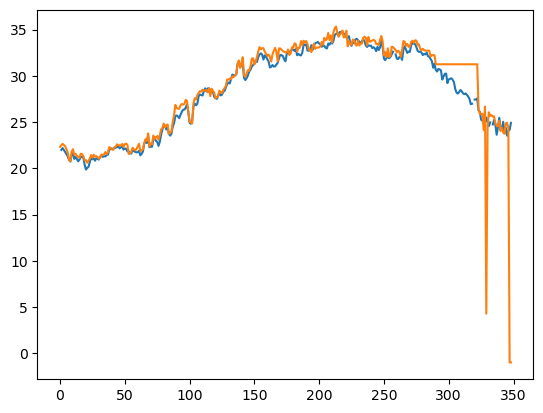

In [378]:
plt.plot(sat_t_tag1_daily)
plt.plot(tag_t_daily)

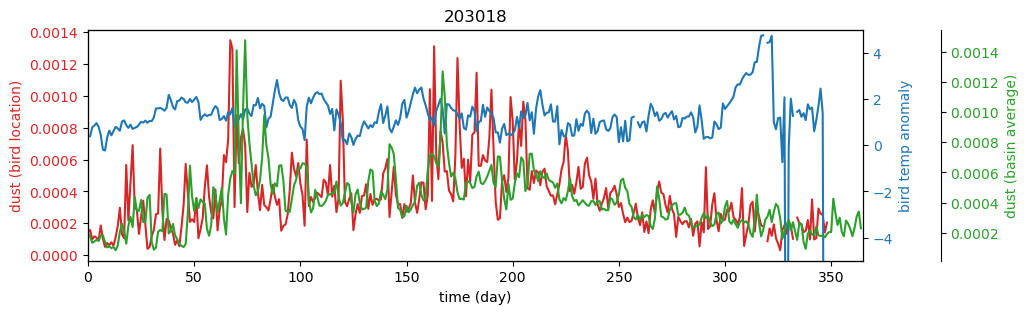

In [451]:
fig, ax1 = plt.subplots(figsize=(10,3))

color = 'tab:red'
ax1.set_xlabel('time (day)')
ax1.set_ylabel('dust (bird location)', color=color)
# ax1.plot(dustplt-da_dust_clim_avg.data, color=color)
# ax1.plot(dustplt, color='green')
ax1.plot(dust_dens_tag1_daily.dust_dens, color=color)
# ax1.set_xlim(50,150)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('bird temp anomaly', color=color)  # we already handled the x-label with ax1
# ax2.plot(np.arange(5,354),(tag_t_daily-sat_t_tag1_clim_daily), color=color)
ax2.plot((tag_t_daily-sat_t_tag1_clim_daily), color=color)
# ax2.plot((sat_t_tag1_daily-sat_t_tag1_clim_daily), color=color)
ax2.set_ylim(-5,5)
ax2.set_xlim(0,365)
ax2.tick_params(axis='y', labelcolor=color)
plt.title(str(idplt))

ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax3.spines.right.set_position(("axes", 1.1))
color = 'tab:green'
ax3.set_ylabel('dust (basin average)', color=color)  # we already handled the x-label with ax1
# ax2.plot(np.arange(5,354),(tag_t_daily-sat_t_tag1_clim_daily), color=color)
# ax3.plot((tag_t_daily-sat_t_tag1_clim_daily), color=color)
ax3.plot(dustplt, color=color)
# ax2.plot((sat_t_tag1_daily-sat_t_tag1_clim_daily), color=color)
# ax3.set_ylim(-5,5)
ax3.set_xlim(0,365)
ax3.tick_params(axis='y', labelcolor=color)
# plt.title(str(idplt))

Text(0.5, 1.0, '203018')

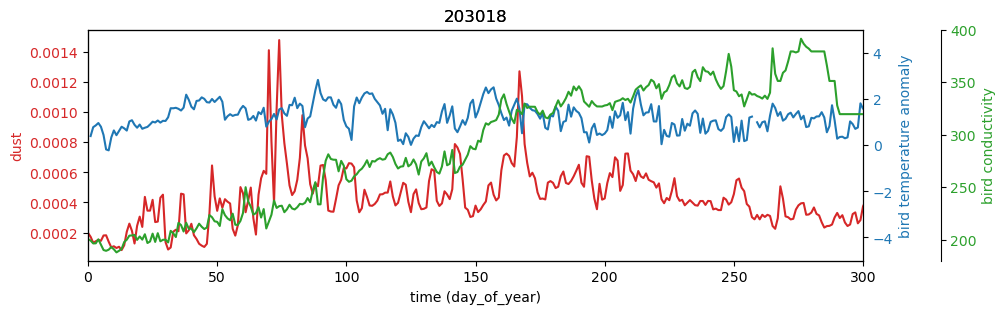

In [461]:
fig, ax1 = plt.subplots(figsize=(10,3))

color = 'tab:red'
ax1.set_xlabel('time (day_of_year)')
ax1.set_ylabel('dust', color=color)
ax1.plot(dustplt, color=color)
# ax1.plot(ta0, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('bird temperature anomaly', color=color)  # we already handled the x-label with ax1
# ax2.plot(ta0, color=color)
ax2.plot((tag_t_daily-sat_t_tag1_clim_daily), color=color)
ax2.set_ylim(-5,5)
ax2.tick_params(axis='y', labelcolor=color)
# ax2.set_ylim(180,400)
# ax2.set_xlim(0,300)
plt.title(str(idplt))

ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax3.spines.right.set_position(("axes", 1.1))

color = 'tab:green'
ax3.set_ylabel('bird conductivity', color=color)  # we already handled the x-label with ax1
ax3.plot(ca0, color=color)
ax3.tick_params(axis='y', labelcolor=color)
ax3.set_ylim(180,400)
ax3.set_xlim(0,300)
plt.title(str(idplt))

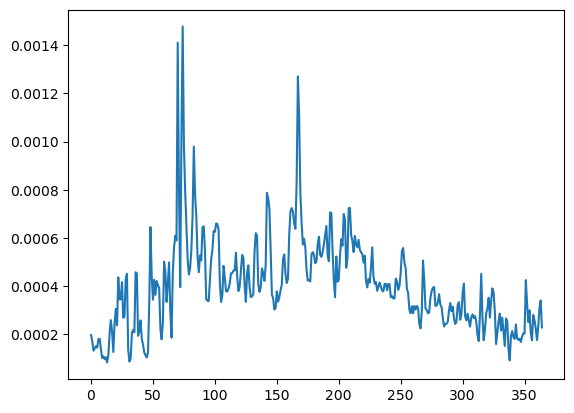

In [449]:
plt.plot(dustplt)

Text(0.5, 1.0, '203018')

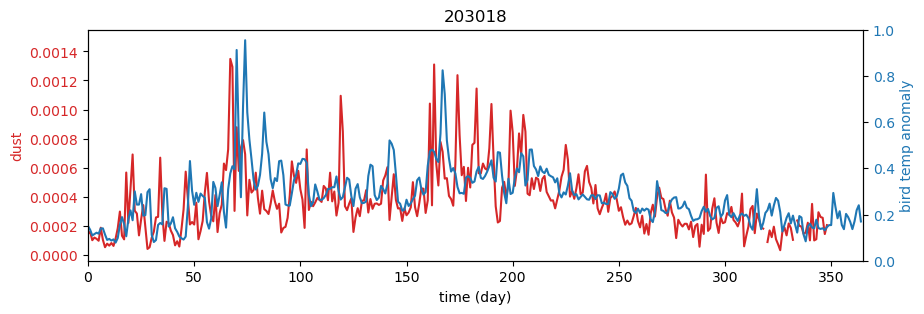

In [452]:
fig, ax1 = plt.subplots(figsize=(10,3))

color = 'tab:red'
ax1.set_xlabel('time (day)')
ax1.set_ylabel('dust', color=color)
# ax1.plot(dustplt-da_dust_clim_avg.data, color=color)
# ax1.plot(dustplt, color=color)
ax1.plot(dust_dens_tag1_daily.dust_dens, color=color)
# ax1.set_xlim(50,150)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('bird temp anomaly', color=color)  # we already handled the x-label with ax1
# ax2.plot((tag_t_daily-sat_t_tag1_clim_daily), color=color)
ax1.plot(dustplt, color=color)
# ax2.plot((sat_t_tag1_daily-sat_t_tag1_clim_daily), color=color)
# ax2.set_ylim(-5,5)
ax2.set_xlim(0,365)
ax2.tick_params(axis='y', labelcolor=color)
plt.title(str(idplt))

Text(0.5, 1.0, '201420')

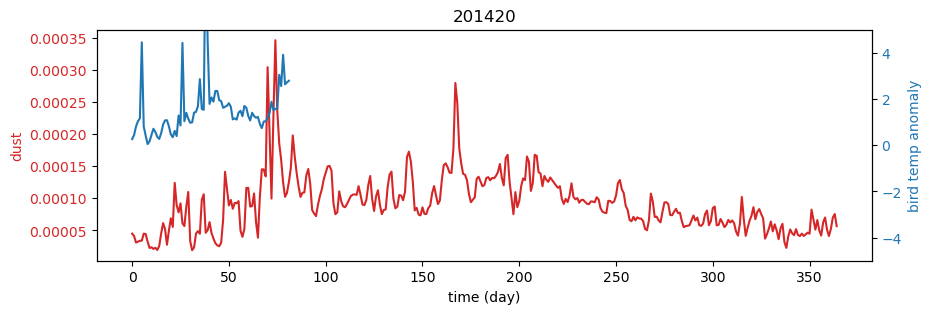

In [357]:
fig, ax1 = plt.subplots(figsize=(10,3))

color = 'tab:red'
ax1.set_xlabel('time (day)')
ax1.set_ylabel('dust', color=color)
# ax1.plot(dustplt-da_dust_clim_avg.data, color=color)
ax1.plot(dustplt, color=color)
# ax1.set_xlim(50,150)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('bird temp anomaly', color=color)  # we already handled the x-label with ax1
ax2.plot((tag_t_daily-sat_t_tag1_clim_daily), color=color)
# ax2.plot((sat_t_tag1_daily-sat_t_tag1_clim_daily), color=color)
ax2.set_ylim(-5,5)
# ax2.set_xlim(50,150)
ax2.tick_params(axis='y', labelcolor=color)
plt.title(str(idplt))

(68.0, 90.0)

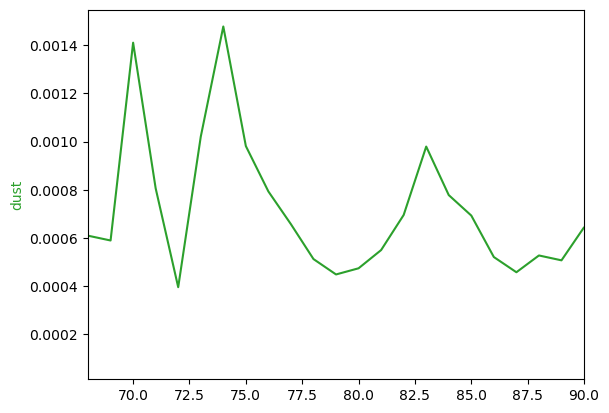

In [462]:
plt.ylabel('dust', color=color)
plt.plot(dustplt, color=color)
plt.xlim(68,90)

In [36]:
year=2021
day_of_year=79
pd.to_datetime(f"{year}-{day_of_year}", format="%Y-%j")

Timestamp('2021-03-20 00:00:00')

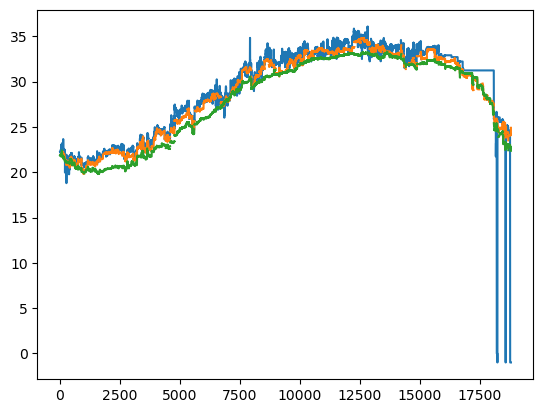

In [194]:
plt.plot(ds_obs.temp.where(ds_obs['id']==idplt,drop=True))
plt.plot(sat_t_tag1)
plt.plot(sat_t_tag1_clim)

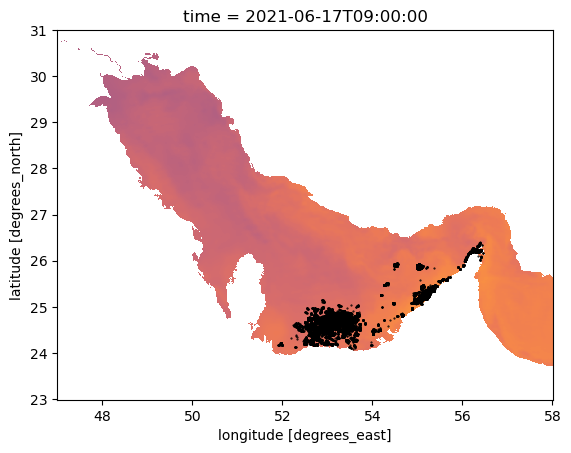

In [20]:
# plt.figure()
sst[ptime].plot(add_colorbar=False, vmin=CLim_l, vmax=CLim_h,cmap=cmocean.cm.thermal)
plt.plot(df.Longitude_1,df.Latitude_1,'ko',markersize = 0.5)
# plt.show()

In [511]:
df.where(df['device_id']==203018,drop='True')

TypeError: DataFrame.where() got an unexpected keyword argument 'drop'

In [316]:
# day_of_year=83
# year=2021

# (ds_dust_daily.dust_dens*mask_pg2.isel(TIME=0)).isel(dayofyear=day_of_year).plot.contourf(levels=np.arange(0,1.1e-3,1e-4))

# date_0 = pd.to_datetime(f"{year}-{day_of_year}", format="%Y-%j")
# date_1 = pd.to_datetime(f"{year}-{day_of_year+1}", format="%Y-%j")

# xpl = ds_obs.x.where(ds_obs['id']==idplt,drop=True).sel(t=slice(date_0,date_1))
# ypl = ds_obs.y.where(ds_obs['id']==idplt,drop=True).sel(t=slice(date_0,date_1))
# plt.plot(xpl,ypl,color='red')

In [315]:
# day_of_year=78

# g_simple = (ds_dust_daily.dust_dens*mask_pg2.isel(TIME=0)).isel(dayofyear=slice(day_of_year,day_of_year+12))\
#                        .plot(x="lon", \
#                              y="lat", \
#                              col="dayofyear", \
#                              col_wrap=3,\
#                              levels=np.arange(0,1.1e-3,1e-4))

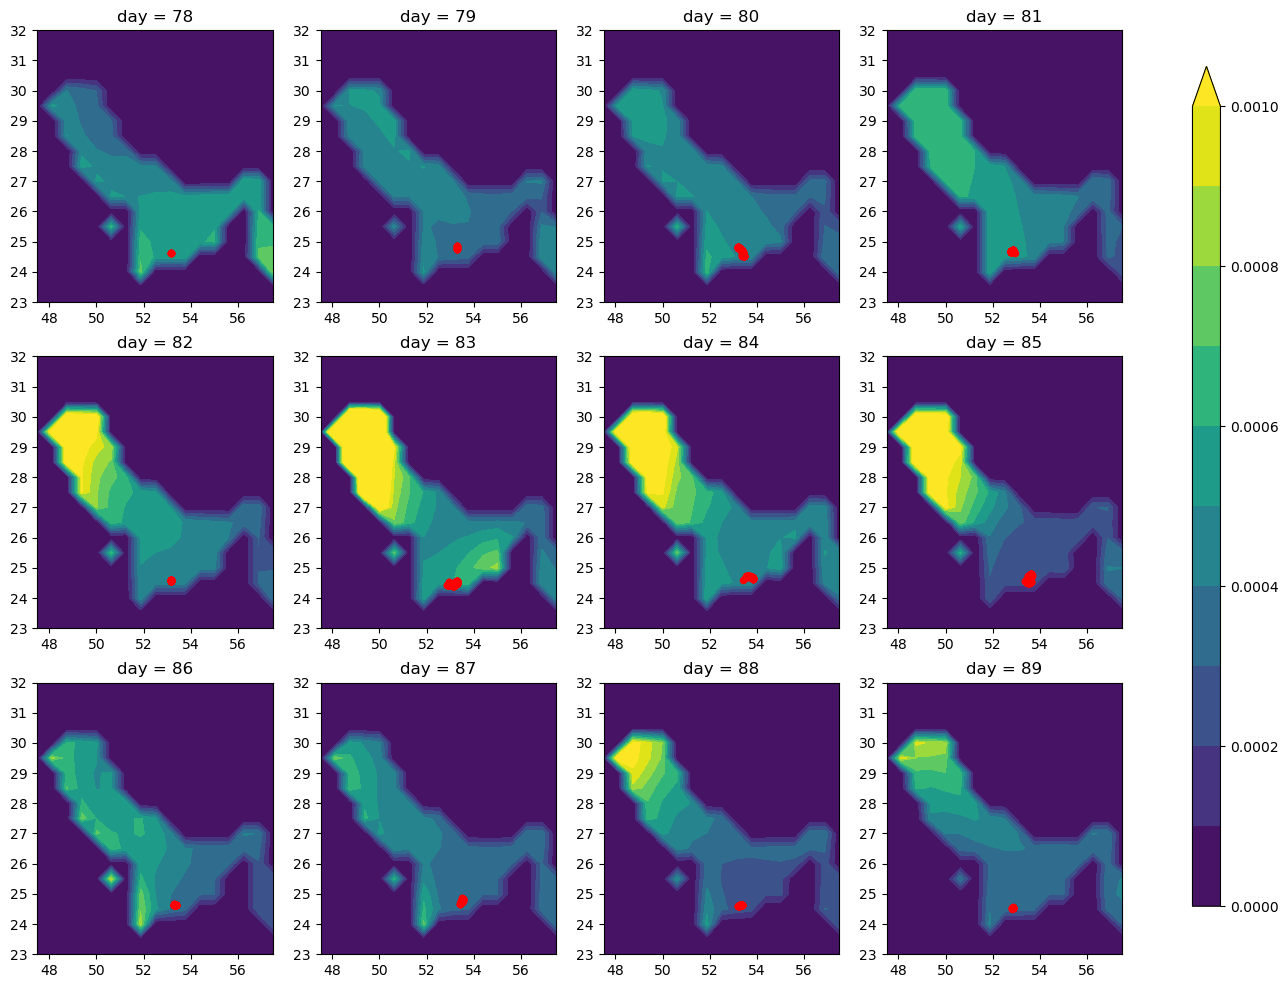

In [326]:
fig, axs = plt.subplots(3,4,figsize=[14,12])
day_of_year=78
year = 2021

for i in range(3):
    for j in range(4):
        ik = i*4+j
#     axs[j,i]
        im=axs[i,j].contourf(ds_dust_daily.lon, \
                      ds_dust_daily.lat, \
                      (ds_dust_daily.dust_dens*mask_pg2.isel(TIME=0)).isel(dayofyear=day_of_year+ik),\
                    levels=np.arange(0,1.1e-3,1e-4),vmin=0,vmax=1.e-3,extend='max')
        axs[i,j].set_title(f'day = {day_of_year+ik}')
        
        date_0 = pd.to_datetime(f"{year}-{day_of_year+ik}", format="%Y-%j")
        date_1 = pd.to_datetime(f"{year}-{day_of_year+ik+1}", format="%Y-%j")

        xpl = ds_obs.x.where(ds_obs['id']==idplt,drop=True).sel(t=slice(date_0,date_1))
        ypl = ds_obs.y.where(ds_obs['id']==idplt,drop=True).sel(t=slice(date_0,date_1))
        axs[i,j].scatter(xpl,ypl,s=20,color='red')
    
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)



In [492]:
import cartopy.crs as ccrs

/home/server/pi/homes/liux8/.conda/envs/dev_scipy/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


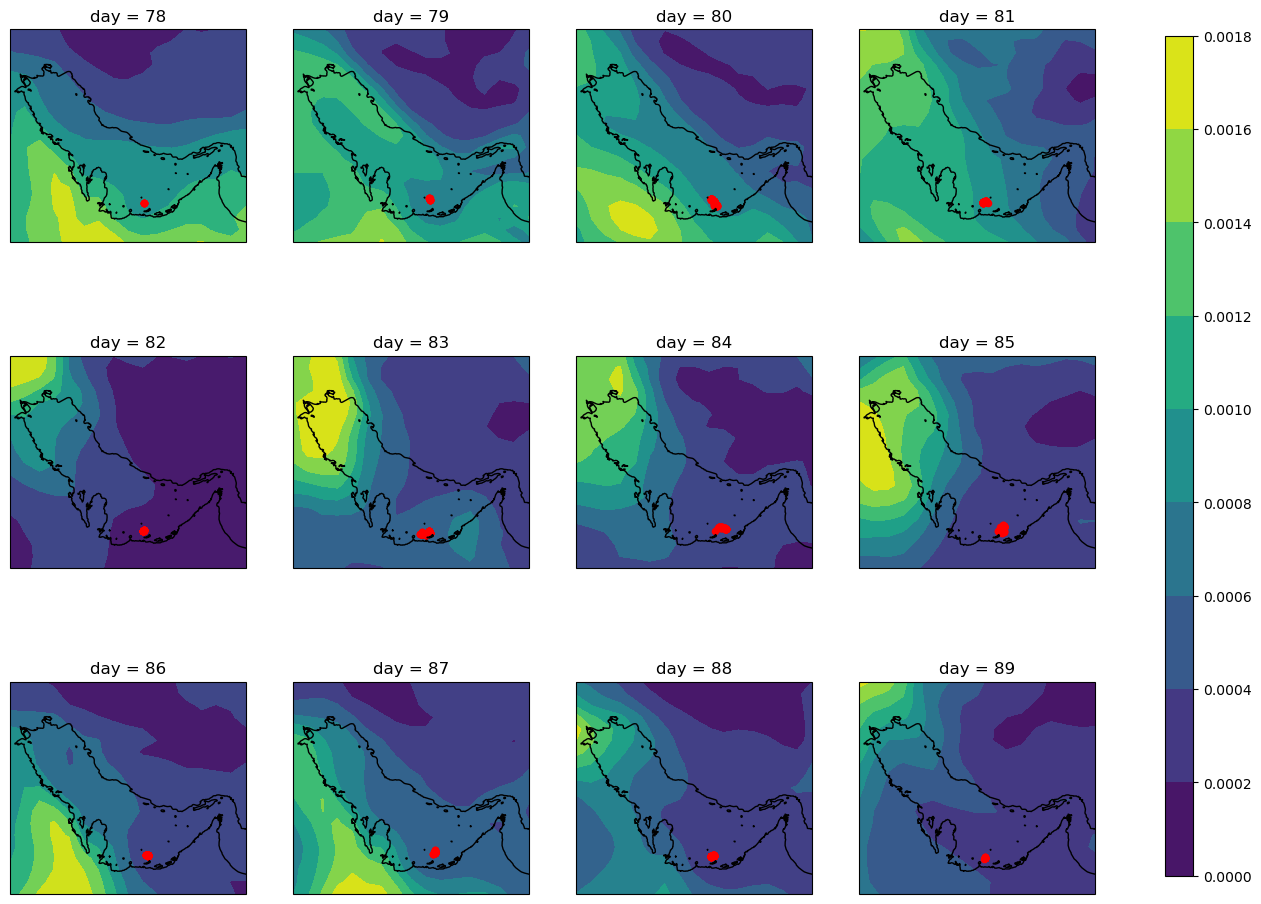

In [495]:
fig, axs = plt.subplots(3,4,figsize=[14,12],subplot_kw=dict(projection=ccrs.PlateCarree()))
day_of_year=78
year = 2021

for i in range(3):
    for j in range(4):
        ik = i*4+j
#     axs[j,i]
        im=axs[i,j].contourf(ds_dust_daily.lon, \
                      ds_dust_daily.lat, \
                      (ds_dust_daily.dust_dens).isel(dayofyear=day_of_year+ik),\
                   transform=ccrs.PlateCarree())
        axs[i,j].set_title(f'day = {day_of_year+ik}')
        axs[i,j].coastlines()
        
        date_0 = pd.to_datetime(f"{year}-{day_of_year+ik}", format="%Y-%j")
        date_1 = pd.to_datetime(f"{year}-{day_of_year+ik+1}", format="%Y-%j")

        xpl = ds_obs.x.where(ds_obs['id']==idplt,drop=True).sel(t=slice(date_0,date_1))
        ypl = ds_obs.y.where(ds_obs['id']==idplt,drop=True).sel(t=slice(date_0,date_1))
        axs[i,j].scatter(xpl,ypl,s=20,color='red')
    
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)



In [224]:
# ds_mur_clim.sel(lat=slice(22.99,31.01))

ds_mur_clim['time'] = ds_mur_clim['time']+np.timedelta64(9, 'h')
# ds_mur_clim['time']
# pd.DateOffset(hours=9)

In [314]:
# day_of_year=78

# g_simple = (sst-ds_mur_clim.sst+273.15).isel(time=slice(day_of_year,day_of_year+12))\
#                        .plot(x="lon", \
#                              y="lat", \
#                              col="time", \
#                              col_wrap=3,\
#                              levels=np.arange(-2,2,0.2))

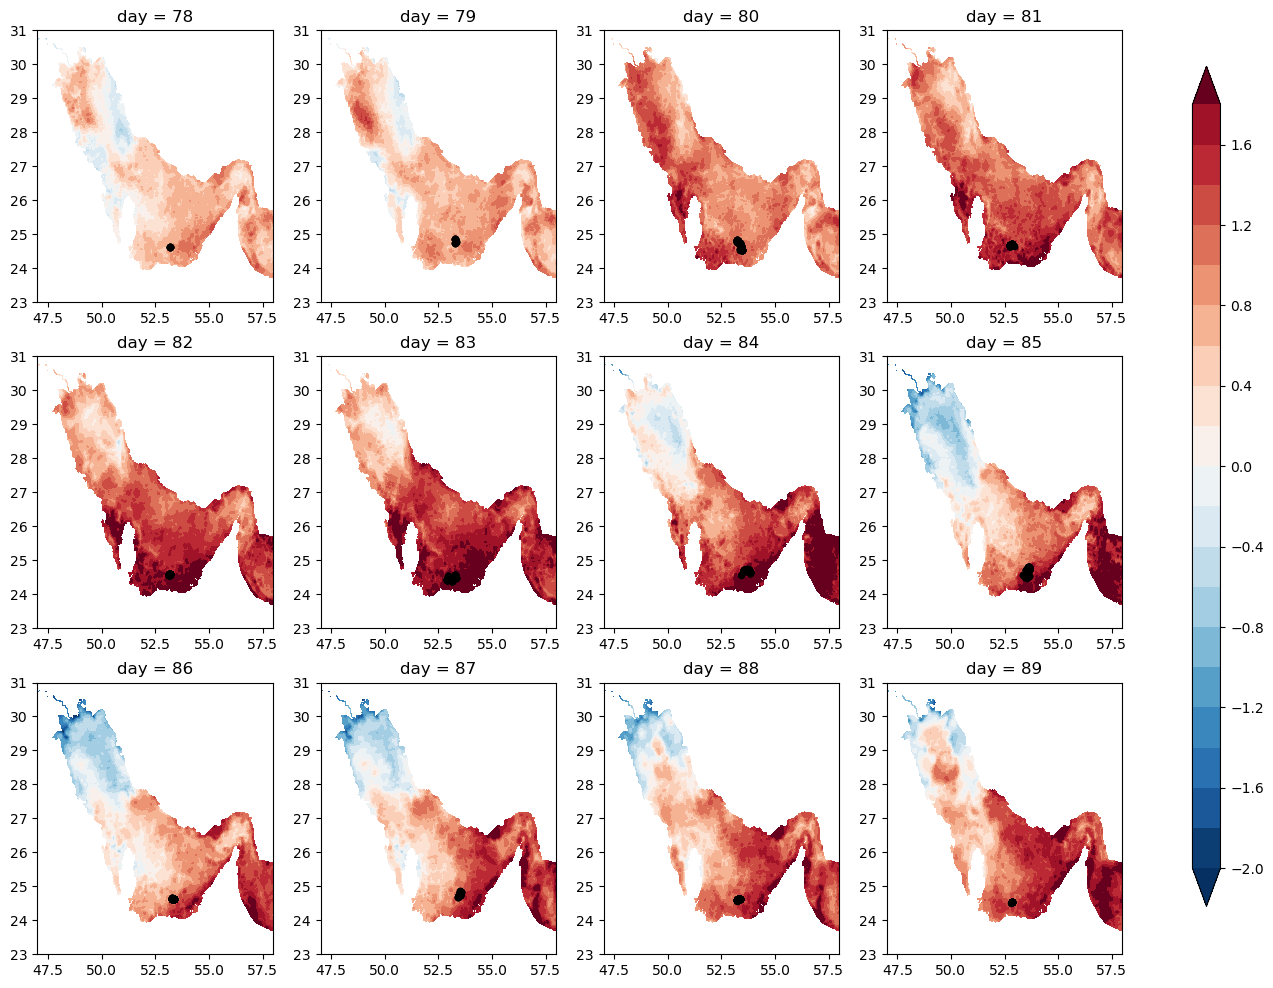

In [324]:
ssta_hor = sst-ds_mur_clim.sst+273.15

fig, axs = plt.subplots(3,4,figsize=[14,12])
day_of_year=78
year = 2021

for i in range(3):
    for j in range(4):
        ik = i*4+j
        im=axs[i,j].contourf(ssta_hor.lon, \
                      ssta_hor.lat, \
                      ssta_hor.isel(time=day_of_year+ik),\
                     levels=np.arange(-2,2,0.2),vmin=-2,vmax=2,extend='both',\
                            cmap='RdBu_r')
        axs[i,j].set_title(f'day = {day_of_year+ik}')
        
        date_0 = pd.to_datetime(f"{year}-{day_of_year+ik}", format="%Y-%j")
        date_1 = pd.to_datetime(f"{year}-{day_of_year+ik+1}", format="%Y-%j")

        xpl = ds_obs.x.where(ds_obs['id']==idplt,drop=True).sel(t=slice(date_0,date_1))
        ypl = ds_obs.y.where(ds_obs['id']==idplt,drop=True).sel(t=slice(date_0,date_1))
        axs[i,j].scatter(xpl,ypl,s=20,color='black')
    
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

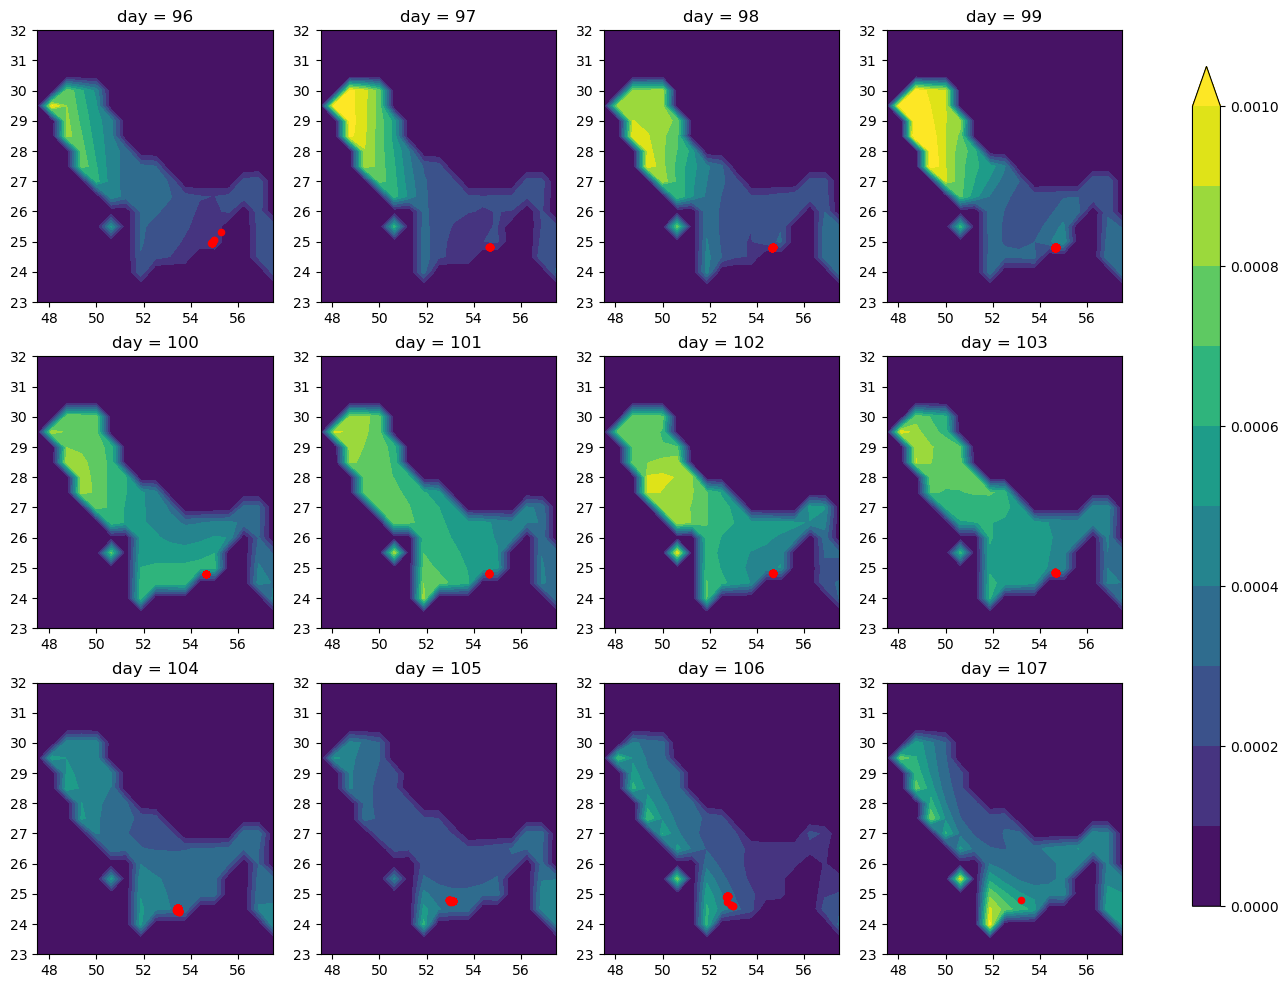

In [321]:
day_of_year=96
year = 2021

fig, axs = plt.subplots(3,4,figsize=[14,12])

for i in range(3):
    for j in range(4):
        ik = i*4+j
#     axs[j,i]
        im=axs[i,j].contourf(ds_dust_daily.lon, \
                      ds_dust_daily.lat, \
                      (ds_dust_daily.dust_dens*mask_pg2.isel(TIME=0)).isel(dayofyear=day_of_year+ik),\
                    levels=np.arange(0,1.1e-3,1e-4),vmin=0,vmax=1.e-3,extend='max')
        axs[i,j].set_title(f'day = {day_of_year+ik}')
        
        date_0 = pd.to_datetime(f"{year}-{day_of_year+ik}", format="%Y-%j")
        date_1 = pd.to_datetime(f"{year}-{day_of_year+ik+1}", format="%Y-%j")

        xpl = ds_obs.x.where(ds_obs['id']==idplt,drop=True).sel(t=slice(date_0,date_1))
        ypl = ds_obs.y.where(ds_obs['id']==idplt,drop=True).sel(t=slice(date_0,date_1))
        axs[i,j].scatter(xpl,ypl,s=20,color='red')
    
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)


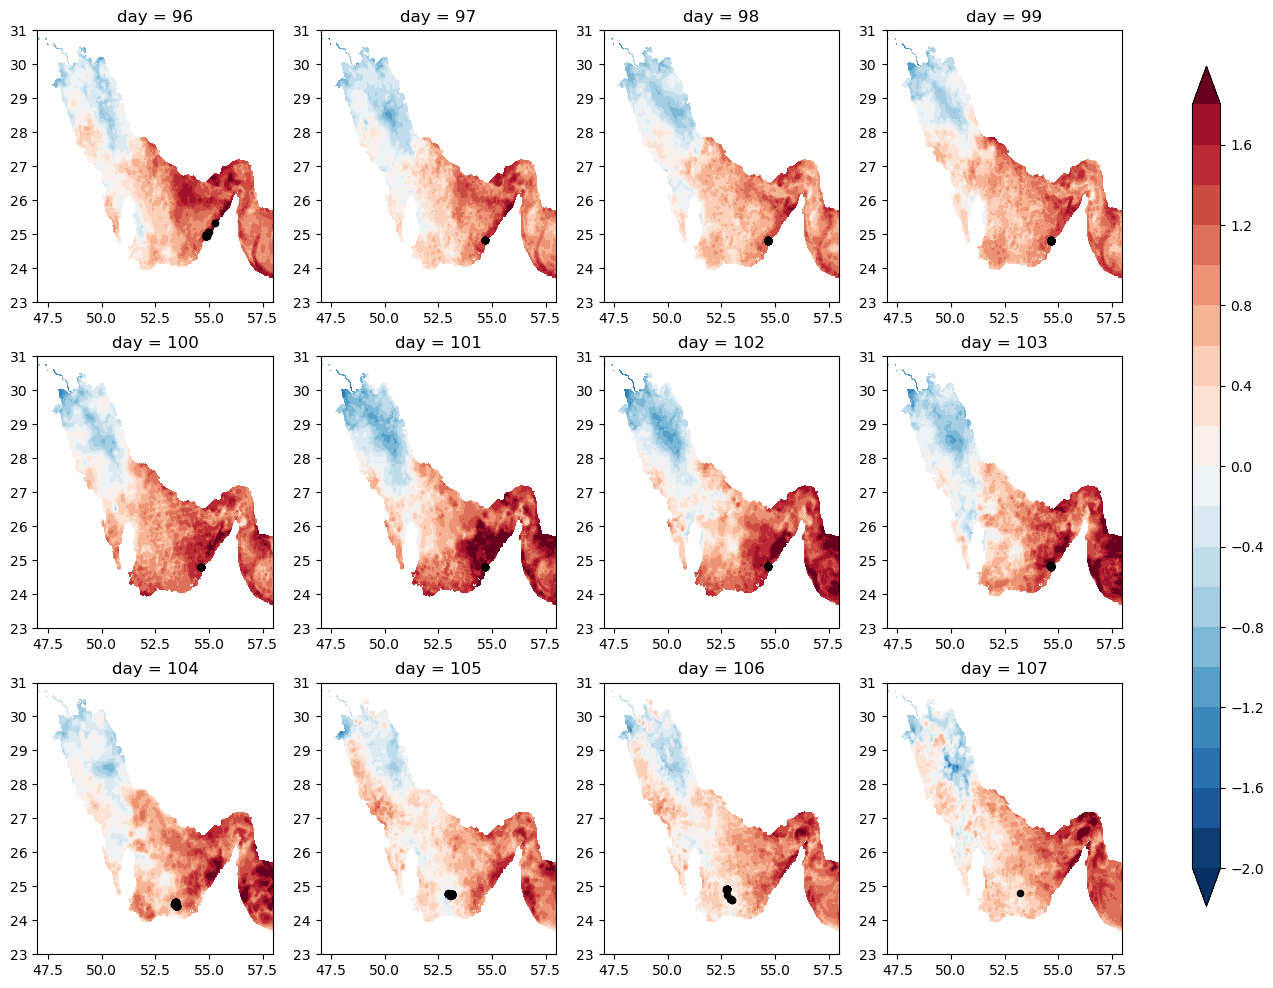

In [323]:
day_of_year=96
year = 2021

ssta_hor = sst-ds_mur_clim.sst+273.15

fig, axs = plt.subplots(3,4,figsize=[14,12])

for i in range(3):
    for j in range(4):
        ik = i*4+j
        im=axs[i,j].contourf(ssta_hor.lon, \
                      ssta_hor.lat, \
                      ssta_hor.isel(time=day_of_year+ik),\
                     levels=np.arange(-2,2,0.2),vmin=-2,vmax=2,extend='both',\
                            cmap='RdBu_r')
        axs[i,j].set_title(f'day = {day_of_year+ik}')
        
        date_0 = pd.to_datetime(f"{year}-{day_of_year+ik}", format="%Y-%j")
        date_1 = pd.to_datetime(f"{year}-{day_of_year+ik+1}", format="%Y-%j")

        xpl = ds_obs.x.where(ds_obs['id']==idplt,drop=True).sel(t=slice(date_0,date_1))
        ypl = ds_obs.y.where(ds_obs['id']==idplt,drop=True).sel(t=slice(date_0,date_1))
        axs[i,j].scatter(xpl,ypl,s=20,color='black')
    
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)


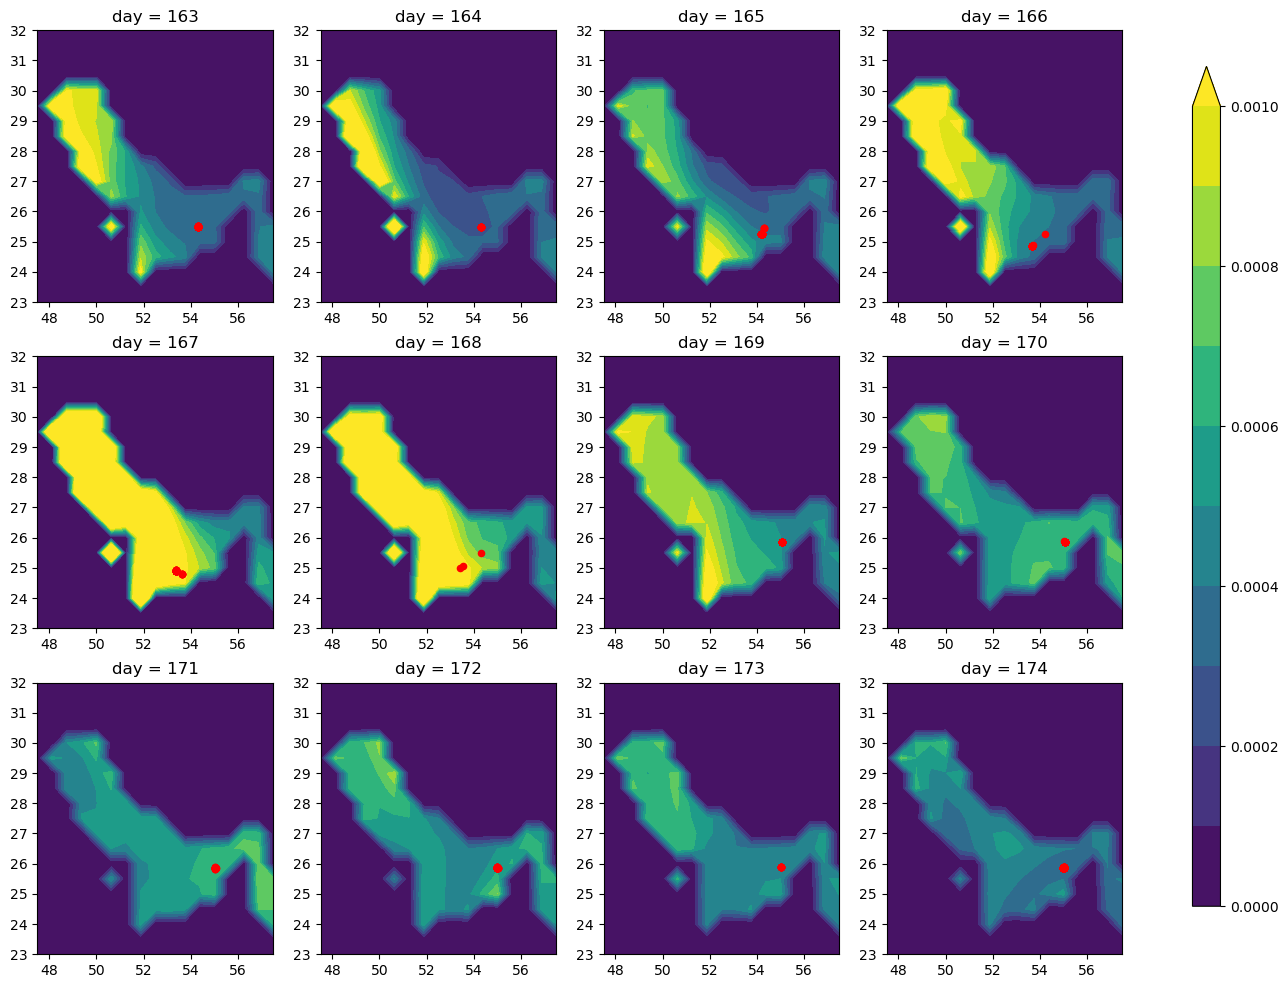

In [330]:
day_of_year=163
year = 2021

fig, axs = plt.subplots(3,4,figsize=[14,12])

for i in range(3):
    for j in range(4):
        ik = i*4+j
#     axs[j,i]
        im=axs[i,j].contourf(ds_dust_daily.lon, \
                      ds_dust_daily.lat, \
                      (ds_dust_daily.dust_dens*mask_pg2.isel(TIME=0)).isel(dayofyear=day_of_year+ik),\
                    levels=np.arange(0,1.1e-3,1e-4),vmin=0,vmax=1.e-3,extend='max')
        axs[i,j].set_title(f'day = {day_of_year+ik}')
        
        date_0 = pd.to_datetime(f"{year}-{day_of_year+ik}", format="%Y-%j")
        date_1 = pd.to_datetime(f"{year}-{day_of_year+ik+1}", format="%Y-%j")

        xpl = ds_obs.x.where(ds_obs['id']==idplt,drop=True).sel(t=slice(date_0,date_1))
        ypl = ds_obs.y.where(ds_obs['id']==idplt,drop=True).sel(t=slice(date_0,date_1))
        xpl = xpl.where(xpl!=0)
        ypl = ypl.where(ypl!=0)
        axs[i,j].scatter(xpl,ypl,s=20,color='red')
    
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)


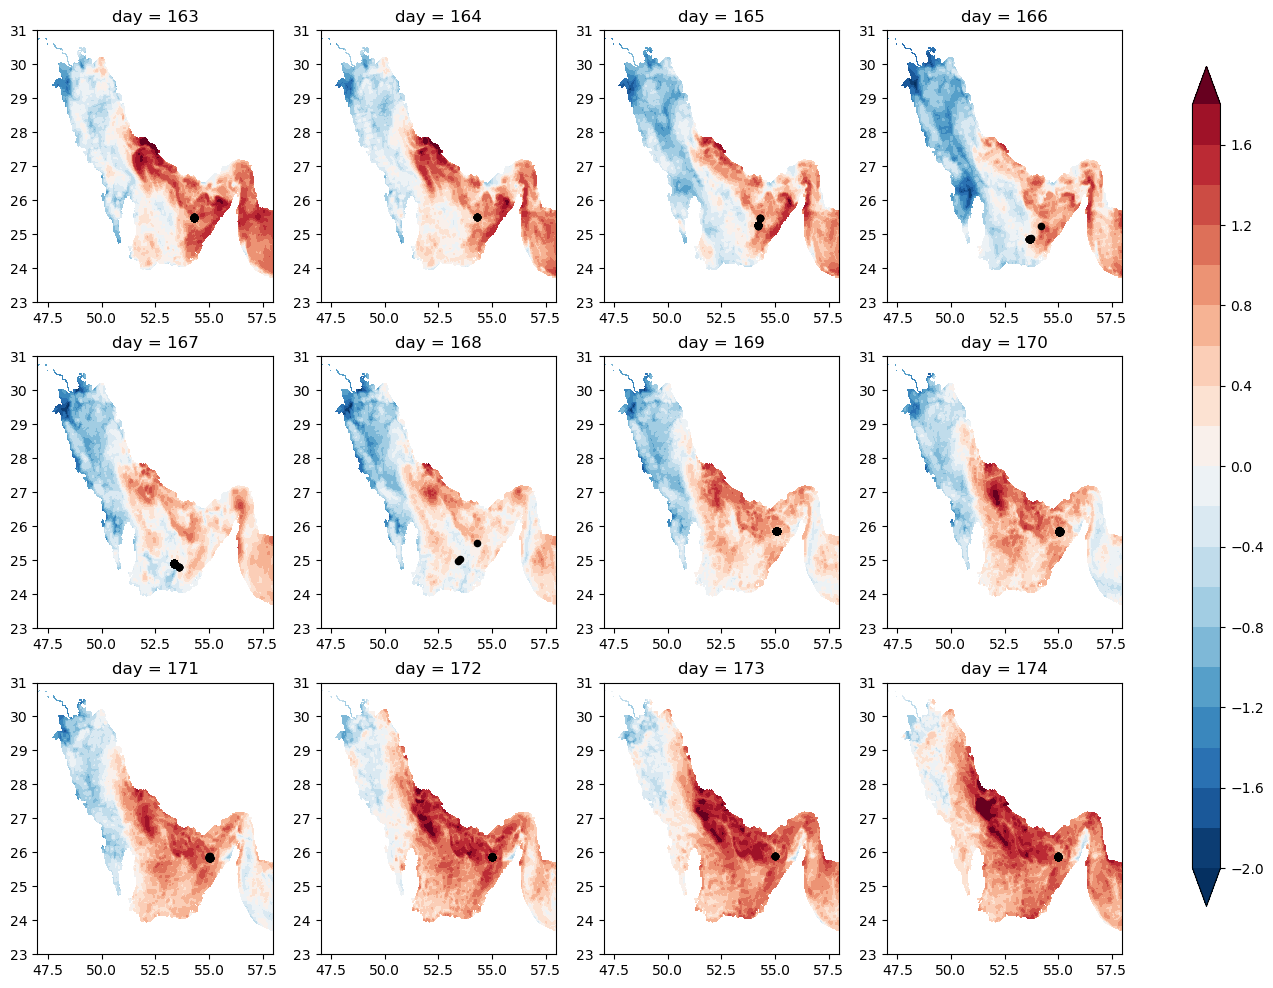

In [331]:
day_of_year=163
year = 2021

ssta_hor = sst-ds_mur_clim.sst+273.15

fig, axs = plt.subplots(3,4,figsize=[14,12])

for i in range(3):
    for j in range(4):
        ik = i*4+j
        im=axs[i,j].contourf(ssta_hor.lon, \
                      ssta_hor.lat, \
                      ssta_hor.isel(time=day_of_year+ik),\
                     levels=np.arange(-2,2,0.2),vmin=-2,vmax=2,extend='both',\
                            cmap='RdBu_r')
        axs[i,j].set_title(f'day = {day_of_year+ik}')
        
        date_0 = pd.to_datetime(f"{year}-{day_of_year+ik}", format="%Y-%j")
        date_1 = pd.to_datetime(f"{year}-{day_of_year+ik+1}", format="%Y-%j")

        xpl = ds_obs.x.where(ds_obs['id']==idplt,drop=True).sel(t=slice(date_0,date_1))
        ypl = ds_obs.y.where(ds_obs['id']==idplt,drop=True).sel(t=slice(date_0,date_1))
        xpl = xpl.where(xpl!=0)
        ypl = ypl.where(ypl!=0)
        axs[i,j].scatter(xpl,ypl,s=20,color='black')
    
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

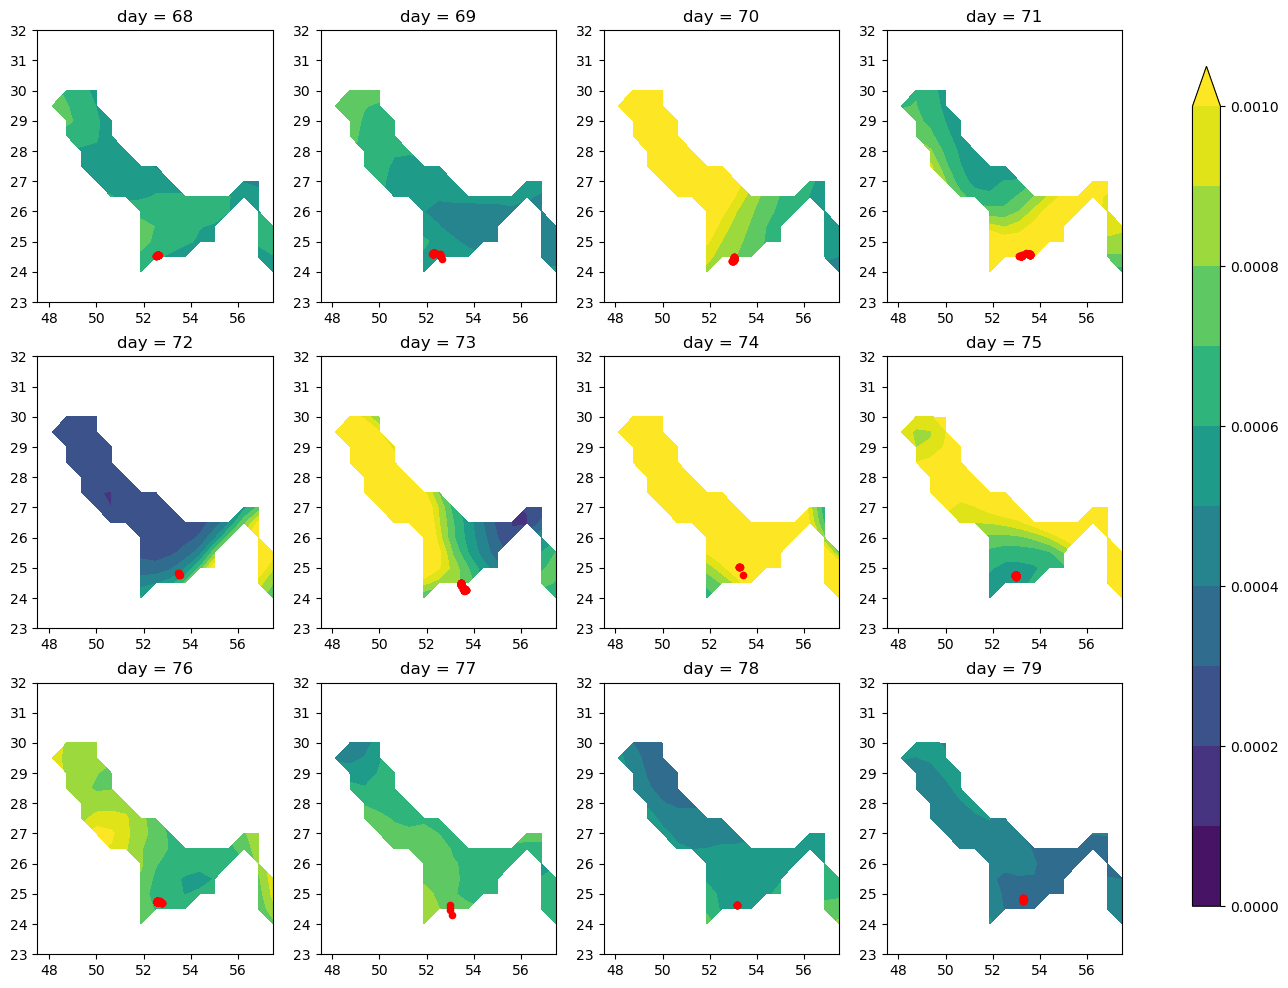

In [463]:
fig, axs = plt.subplots(3,4,figsize=[14,12])
day_of_year=68
year = 2021

for i in range(3):
    for j in range(4):
        ik = i*4+j
#     axs[j,i]
        im=axs[i,j].contourf(ds_dust_daily.lon, \
                      ds_dust_daily.lat, \
                      (ds_dust_daily.dust_dens*mask_pg2.isel(TIME=0)).isel(dayofyear=day_of_year+ik),\
                    levels=np.arange(0,1.1e-3,1e-4),vmin=0,vmax=1.e-3,extend='max')
        axs[i,j].set_title(f'day = {day_of_year+ik}')
        
        date_0 = pd.to_datetime(f"{year}-{day_of_year+ik}", format="%Y-%j")
        date_1 = pd.to_datetime(f"{year}-{day_of_year+ik+1}", format="%Y-%j")

        xpl = ds_obs.x.where(ds_obs['id']==idplt,drop=True).sel(t=slice(date_0,date_1))
        ypl = ds_obs.y.where(ds_obs['id']==idplt,drop=True).sel(t=slice(date_0,date_1))
        axs[i,j].scatter(xpl,ypl,s=20,color='red')
    
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)


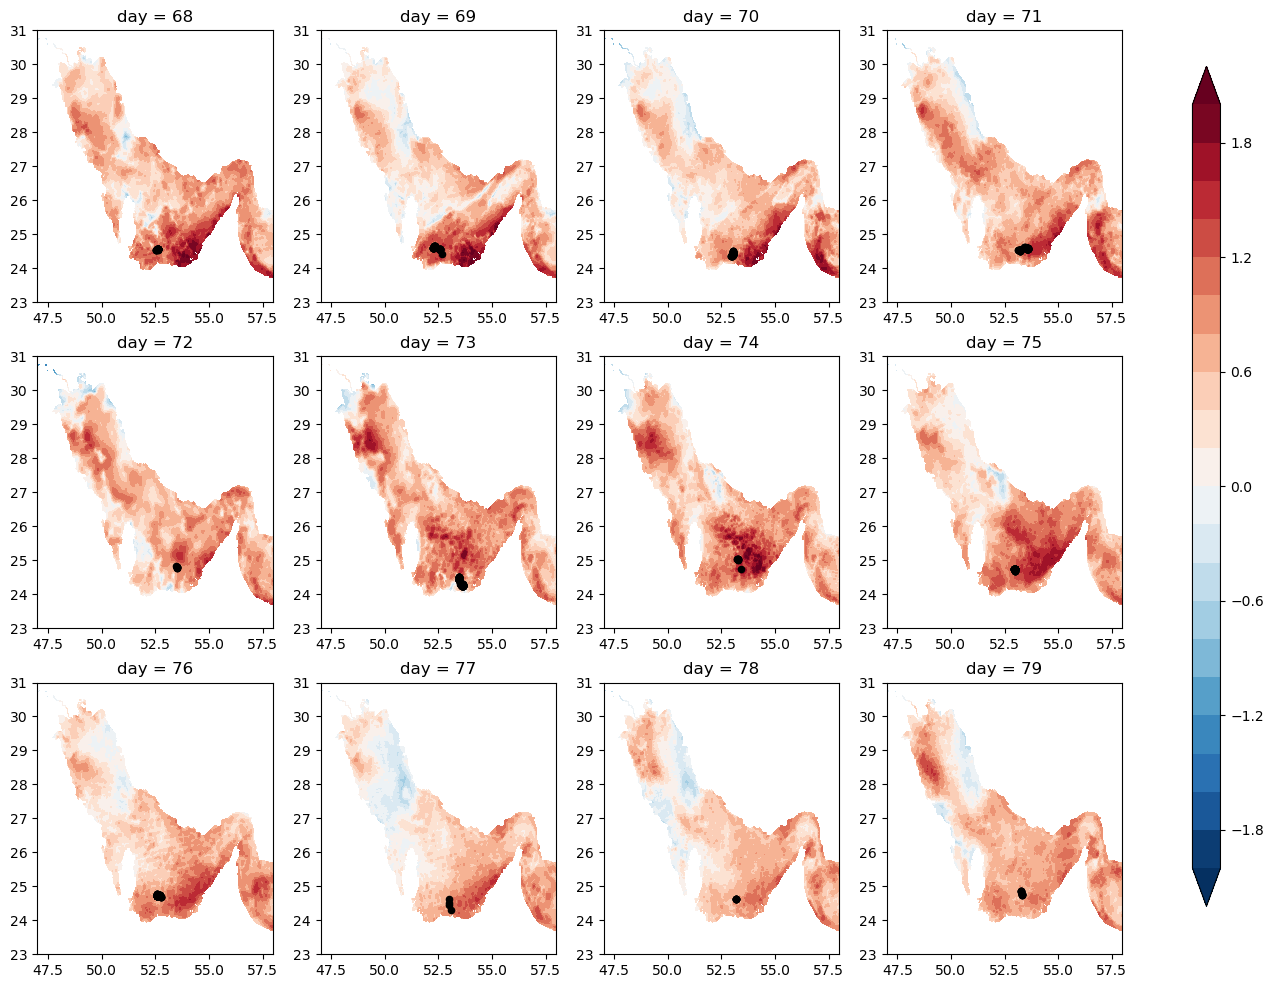

In [465]:
day_of_year=68
year = 2021

ssta_hor = sst-ds_mur_clim.sst+273.15

fig, axs = plt.subplots(3,4,figsize=[14,12])

for i in range(3):
    for j in range(4):
        ik = i*4+j
        im=axs[i,j].contourf(ssta_hor.lon, \
                      ssta_hor.lat, \
                      ssta_hor.isel(time=day_of_year+ik),\
                     levels=np.arange(-2,2.2,0.2),vmin=-2,vmax=2,extend='both',\
                            cmap='RdBu_r')
        axs[i,j].set_title(f'day = {day_of_year+ik}')
        
        date_0 = pd.to_datetime(f"{year}-{day_of_year+ik}", format="%Y-%j")
        date_1 = pd.to_datetime(f"{year}-{day_of_year+ik+1}", format="%Y-%j")

        xpl = ds_obs.x.where(ds_obs['id']==idplt,drop=True).sel(t=slice(date_0,date_1))
        ypl = ds_obs.y.where(ds_obs['id']==idplt,drop=True).sel(t=slice(date_0,date_1))
        xpl = xpl.where(xpl!=0)
        ypl = ypl.where(ypl!=0)
        axs[i,j].scatter(xpl,ypl,s=20,color='black')
    
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

Text(0.5, 1.0, '203018')

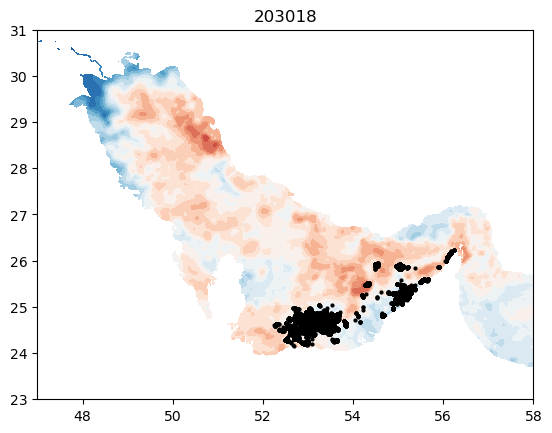

In [469]:
plt.contourf(ssta_hor.lon, \
                      ssta_hor.lat, \
                      ssta_hor.isel(time=0),\
                     levels=np.arange(-2,2.2,0.2),vmin=-2,vmax=2,extend='both',\
                            cmap='RdBu_r')        
date_0 = pd.to_datetime(f"{year}-{1}", format="%Y-%j")
date_1 = pd.to_datetime(f"{year}-{348}", format="%Y-%j")

xpl = ds_obs.x.where(ds_obs['id']==idplt,drop=True).sel(t=slice(date_0,date_1))
ypl = ds_obs.y.where(ds_obs['id']==idplt,drop=True).sel(t=slice(date_0,date_1))
xpl = xpl.where(xpl!=0)
ypl = ypl.where(ypl!=0)
plt.scatter(xpl,ypl,s=4,color='black')
plt.title(idplt)

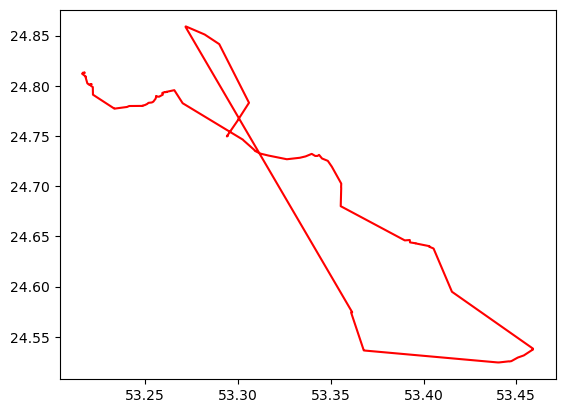

In [161]:
xpl = ds_obs.x.where(ds_obs['id']==idplt,drop=True).sel(t=slice('2021-03-20','2021-03-21'))
ypl = ds_obs.y.where(ds_obs['id']==idplt,drop=True).sel(t=slice('2021-03-20','2021-03-21'))

plt.plot(xpl,ypl,color='red')

In [1]:
sst[ptime].plot(add_colorbar=False, vmin=CLim_l, vmax=CLim_h,cmap=cmocean.cm.thermal)

plt.scatter(x,y,c=temp,vmin=CLim_l, vmax=CLim_h,cmap=cmocean.cm.thermal,markersize = 0.5)
plt.xlim([51, 58])
plt.ylim(23, 27)
plt.colorbar()

NameError: name 'sst' is not defined

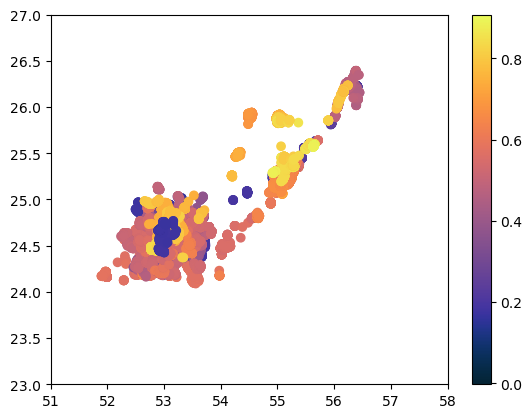

In [25]:
# sst[ptime].plot(add_colorbar=False, vmin=CLim_l, vmax=CLim_h,cmap=cmocean.cm.thermal)

plt.scatter(x,y,c=conduc/42.914*0.1,cmap=cmocean.cm.thermal)
plt.xlim([51, 58])
plt.ylim(23, 27)
plt.colorbar()

In [27]:
import gsw

In [31]:
t

<xarray.DataArray 'date' (z: 35560)>
array(['2021-01-01T05:08:38.000000000', '2021-01-01T05:09:49.000000000',
       '2021-01-01T05:11:14.000000000', ...,
       '2021-01-11T12:27:48.000000000', '2021-01-11T12:29:10.000000000',
       '2021-01-11T12:30:21.000000000'], dtype='datetime64[ns]')
Coordinates:
  * z        (z) datetime64[ns] 2021-01-01T05:08:38 ... 2021-01-11T12:30:21

In [34]:
s = gsw.SP_from_C(conduc.data,temp.data,temp.data*0)

In [37]:
c0 = gsw.C_from_SP(40,temp.data,temp.data*0)
c0

array([56.41621704, 56.39817841, 56.36210587, ..., 55.80379053,
       55.88474162, 56.06474833])

Satellite vs. bird: 0.8663084334662914
Orig model vs. bird: 1.0816432644980183
Modified model vs. bird: 1.0304284577012357


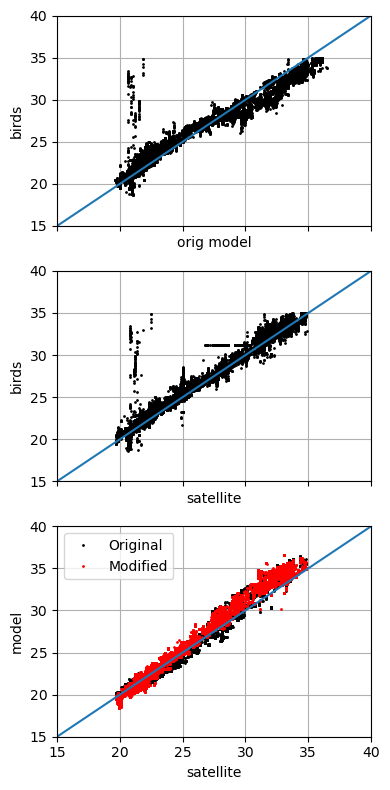

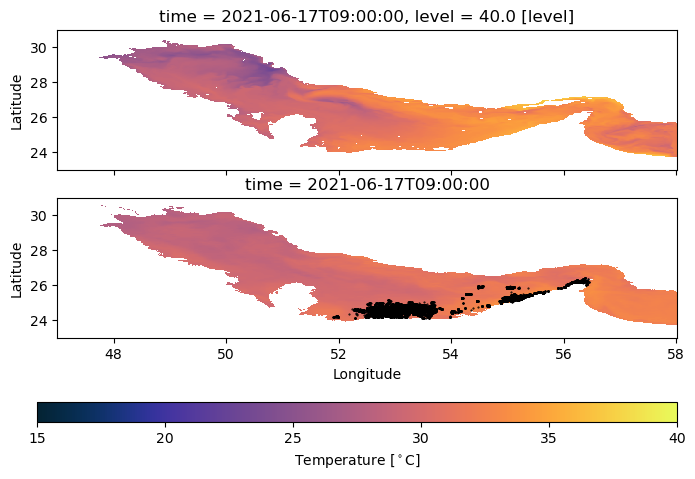

In [15]:
# file0 = 'model_satellite/' + yr + '_surf_GETM_marv.nc'
file0 = '/home/server/pi/homes/liux8/work/GETM/hpc2-files/GETM_shrad/getm/setups/era5frc_hotstart_01012021/data_002/regions/surface.nc'
fm_M = xr.open_dataset(file0)
#surface only
fmm2_M=fm_M.isel(level=0)

file0 = 'model_satellite/JanAug2021_surf_GETM_orig.nc'

fm = xr.open_dataset(file0)

fmm2=fm.isel(level=0) #original

df=df.dropna(subset=['Latitude_1'])
df = df[df['ext_temperature_C'] <= 35]
df = df[df['ext_temperature_C'] > 5]

files=glob.glob('model_satellite/' + yr + '_satellite/' + yr + '*subset.nc')
fd=xr.open_mfdataset(files)
sst=fd.analysed_sst-273.15
sst.attrs["units"]="deg C"
sst.attrs["long_name"]="Sea Surface Temperature"
    
fig2,ax_1 = plt.subplots(3,1,figsize=(4, 8),sharey=True,sharex=True)

df['date']=pd.to_datetime(df['date'],format='%Y-%m-%d %H:%M:%S')

x = xr.DataArray(df.Longitude_1, dims="z")
y = xr.DataArray(df.Latitude_1, dims="z")
t = xr.DataArray(df.date, dims="z")

fmm=fmm2.temp.interp(lonc=x,latc=y,time=t) #original
fmm_M=fmm2_M.temp.interp(lonc=x,latc=y,time=t) #Marvin

sat_t=sst.interp(time=t,lat=y,lon=x)

# r=sqrt(sum((obs(:)-est(:)).^2)/numel(obs));

ax_1[0].plot(fmm,df.ext_temperature_C,'ko',markersize = ms1)
# ax_1[0].plot(fmm_M,df.ext_temperature_C,'ro',markersize = ms1)
ax_1[1].plot(sat_t,df.ext_temperature_C,'ko',markersize = ms1)
ax_1[2].plot(sat_t,fmm,'ko',markersize = ms1,label='Original')
ax_1[2].plot(sat_t,fmm_M,'ro',markersize = ms1,label='Modified')
ax_1[2].legend()
plt.xlim([CLim_l, CLim_h]),plt.ylim([CLim_l, CLim_h])

print('Satellite vs. bird: ' + str(RMSE(sat_t,df.ext_temperature_C)))
print('Orig model vs. bird: ' + str(RMSE(fmm,df.ext_temperature_C)))
print('Modified model vs. bird: ' + str(RMSE(fmm_M,df.ext_temperature_C)))
# RMSE(sat_t,asd)

for aa in np.arange(3):
    ax_1[aa].plot([CLim_l,CLim_h],[CLim_l,CLim_h])
    ax_1[aa].set_ylabel('birds')
    ax_1[aa].grid()
ax_1[0].set_xlabel(file0[-7:-3]  + ' model'),ax_1[2].set_ylabel('model')
ax_1[1].set_xlabel('satellite'),ax_1[2].set_xlabel('satellite')

plt.tight_layout()
# plt.savefig('figs/birdcomp_' + file1[:-4] + file0[-8:-3] + 'n.png', dpi=300, transparent=False, bbox_inches='tight')

# tt=df.date.dt.strftime('%Y-%m-%d')
# tt=tt.min()
fm2=fm.sel(time=sst.time[ptime], method='nearest')
fm3=fm2#.isel(level=40)

fig,ax = plt.subplots(2,1,figsize=(8, 4),sharey=True,sharex=True)

# fm2.temp.ax.plot()

a = fm3.temp.plot(ax=ax[0],add_colorbar=False, vmin=CLim_l, vmax=CLim_h,cmap=cmocean.cm.thermal)
ax[0].set(xlabel=None,ylabel='Latitude')
sst[ptime].plot(ax=ax[1],add_colorbar=False, vmin=CLim_l, vmax=CLim_h,cmap=cmocean.cm.thermal)
ax[1].set(xlabel='Longitude',ylabel='Latitude')
ax[1].plot(df.Longitude_1,df.Latitude_1,'ko',markersize = 0.5)
# plt.xlim([50, 54]),plt.ylim([23.5, 27.5]),
# cbar_kwargs={
#     "orientation": "horizontal",
#     "shrink": 0.8,
#     "aspect": 40,
#     "pad": 0.2,
# })
# plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
# plt.tight_layout()
cbar_ax = fig.add_axes([0.1, -0.1, .8, .05]) #left, bottom, width, height
fig.colorbar(a, cax=cbar_ax , orientation="horizontal",label="Temperature [$^\circ$C]")
# ff=f.split('/')
# f=ff[1].split('-')
# plt.savefig('figs/comp' + file1[:-4] + file0[-8:-3] + 'n.png', dpi=300, transparent=False, bbox_inches='tight')

# Some extra satellite vs model comparisons
# Make sure not to use same data points, i.e., don't ask for pre-/post- model data

# startdate = pd.Timestamp('2021-04-25 09:00:00')
# ts = [startdate + pd.Timedelta('5 days')*i for i in range(12)]

# # timmmm='2021-06-15 09:00:00'
# fm_sat=fm.sel(time=ts, method='nearest')

# sst_1=sst.sel(time=ts, method='nearest')

# fm_sat=fm_sat.interp(lonc=sst_1.lon,latc=sst_1.lat)

# aaa=sst_1-fm_sat

# aaa.temp[1].plot()

# g_simple = aaa.temp.plot(x='lon', y='lat', col='time', col_wrap=4)